In [1]:
import h3ppy
import scipy
import numpy as np
import matplotlib.pyplot as plt
from pandas import read_csv
from astropy.io import fits
from lmfit.models import LinearModel

import os

spec_dir = os.path.abspath("./../spec/") + "/"
plots_dir = os.path.abspath("./../plots/altitude") + "/"

juph2 = read_csv('./profiles/JupH2Plot.csv', sep=',', header=None, skiprows=1)
juph3p = read_csv('./profiles/JupH3+Plot.csv', sep=',', header=None, skiprows=1)
juptp = read_csv('./profiles/JupTP.csv', sep=',', header=None, skiprows=1)
juptao = read_csv('./profiles/JupTao.csv', sep=',', header=None, skiprows=1)

waveh2 = fits.open("h2_wave_to_fit.fits", ignore_missing_end=True)[0].data
waveh3p = fits.open("h3p_wave_to_fit.fits", ignore_missing_end=True)[0].data


def non_LTE_scaling(h2temp, h2dens):
    temp_list = [200, 300, 600, 1000, 1500, 2000, 2500, 3000, 3500, 4000, 4500, 5000]
    dens_list = [1e8, 1e10, 1e12, 1e14, 1e16, 1e18, 1e20, 1e22]

    scalings = np.array([
        [0.0000, 0.0014, 0.1182, 0.9306, 0.9993, 1.0000, 1.0002, 1.],
        [0.0000, 0.0001, 0.0067, 0.3931, 0.9848, 0.9998, 1.0000, 1.],
        [0.0000, 0.0000, 0.0011, 0.0313, 0.7449, 0.9965, 1.0000, 1.],
        [0.0000, 0.0000, 0.0013, 0.0108, 0.4955, 0.9866, 0.9999, 1.],
        [0.0000, 0.0000, 0.0013, 0.0064, 0.3640, 0.9701, 0.9997, 1.],
        [0.0000, 0.0000, 0.0011, 0.0049, 0.2894, 0.9499, 0.9995, 1.],
        [0.0000, 0.0000, 0.0010, 0.0042, 0.2469, 0.9299, 0.9992, 1.],
        [0.0000, 0.0000, 0.0010, 0.0042, 0.2469, 0.9299, 0.9992, 1.],
        [0.0000, 0.0000, 0.0008, 0.0036, 0.2064, 0.9014, 0.9988, 1.],
        [0.0000, 0.0000, 0.0007, 0.0034, 0.1961, 0.8923, 0.9987, 1.],
        [0.0000, 0.0000, 0.0007, 0.0033, 0.1889, 0.8854, 0.9985, 1.],
        [0.0000, 0.0000, 0.0007, 0.0033, 0.1836, 0.8802, 0.9985, 1.]
    ])

    if h2temp >= temp_list[-1]:
        temp_index = len(temp_list)  # Set to the boundary index
    else:
        temp_index = np.digitize(h2temp, temp_list, right=True)

    if h2dens >= dens_list[-1]:
        dens_index = len(dens_list)  # Set to the boundary index
    else:
        dens_index = np.digitize(h2dens, dens_list, right=True)

    # Ensure the indices are within the valid range
    temp_index = max(0, min(temp_index, len(temp_list) - 1))
    dens_index = max(0, min(dens_index, len(dens_list) - 1))

    # Ensure index not rolling to the other end
    if temp_index <= 0:
        temp_index = 1

    if dens_index <= 0:
        dens_index = 1

    # calculate scaling
    if h2dens > dens_list[-1]:
        scaling = scalings[temp_index][dens_index]
    elif h2temp > temp_list[-1]:
        scaling = scalings[temp_index][dens_index - 1]
    elif h2dens < dens_list[0]:
        scaling = scalings[temp_index - 1][dens_index]
    elif h2temp < temp_list[0]:
        scaling = scalings[temp_index - 1][dens_index - 1]
    else:
        # interpolate two adjacent saclings for a given h2temp
        
        top = scalings[temp_index - 1, :]
        bot = scalings[temp_index, :]
    
        # interpolate top scaling
        
        x = np.log10(np.array(dens_list))
        y = np.copy(top)

        f = scipy.interpolate.interp1d(x, y)
        
        xs = np.arange(x[0], x[-1]+1)

        top_interp = f(np.log10(h2dens))
        
        # fig, ax = plt.subplots(figsize=(6.5, 4))
        # ax.plot(x, y, 'k.')
        # ax.plot(xs, f(xs), 'b-', label='linear')
        # ax.legend()
        
        # interpolate bot scaling
        
        x = np.log10(np.array(dens_list))
        y = np.copy(bot)
        
        f = scipy.interpolate.interp1d(x, y)
    
        xs = np.arange(x[0], x[-1]+1)
        
        bot_interp = f(np.log10(h2dens))
    
        # fig, ax = plt.subplots(figsize=(6.5, 4))
        # ax.plot(x, y, 'k.')
        # ax.plot(xs, f(xs), 'b-', label='linear')
        # ax.legend()
        
    
        # interpolate between top_interp and bot_interp
        
        x = [temp_list[temp_index - 1], temp_list[temp_index]]
        y = [top_interp, bot_interp]
    
        f = scipy.interpolate.interp1d(x, y)

        xs = np.arange(x[0], x[-1]+1, 10)

        scaling = f(h2temp)
    
        # fig, ax = plt.subplots(figsize=(6.5, 4))
        # ax.plot(x, y, 'k.')
        # ax.plot(xs, f(xs), 'b-', label='linear')
        # ax.legend()

    return scaling


h3p_alt = juph3p[1].to_numpy()
h3p_local_dens = juph3p[0].to_numpy()

k_sort = np.argsort(h3p_alt)
h3p_alt = h3p_alt[k_sort]
h3p_local_dens = h3p_local_dens[k_sort]

h2_alt = juph2[1].to_numpy()
h2_local_dens = juph2[0].to_numpy()

h2_sort = np.argsort(h2_alt)
h2_alt = h2_alt[h2_sort]
h2_local_dens = h2_local_dens[h2_sort]

jup_p = juptp[1].to_numpy()
jup_t = juptp[0].to_numpy()

jup_tao_h = juptao[1].to_numpy()
jup_tao_t = juptao[0].to_numpy()

alt_scale = np.arange(200, 2000, 20)

h2_interp = np.interp(alt_scale, h2_alt, h2_local_dens)
h3p_interp = np.interp(alt_scale, h3p_alt, h3p_local_dens)

h3p_col_dens = np.sum(h3p_interp*1e6*20e3) # 20 km per layer defined in the alt_scale
h2_col_dens = np.sum(h2_interp*1e6*20e3)

H = 27 # Jupiter scale height [km]
jup_h = -H * np.log(jup_p)

h3p_interp_m3 = h3p_interp*1e6

h2_interp_m3 = h2_interp*1e6
# h2_interp_m3[h2_interp_m3 > 1e20] = 1e20


# t_interp = np.interp(alt_scale, jup_tao_h, jup_tao_t)

mode = [1, 2, 3, 4]

In [57]:
waveh2

array([2.1214101, 2.1214392, 2.1214683, 2.1214972, 2.1215262, 2.1215553,
       2.1215844, 2.1216135, 2.1216426, 2.1216717, 2.1217008, 2.1217299,
       2.121759 , 2.121788 , 2.121817 , 2.1218462, 2.1218753, 2.1219044,
       2.1219335, 2.1219625, 2.1219916, 2.1220207, 2.1220498, 2.122079 ,
       2.122108 , 2.122137 , 2.1221662, 2.1221952, 2.1222243, 2.1222534,
       2.4061255, 2.4061584, 2.4061916, 2.4062245, 2.4062576, 2.4062908,
       2.4063237, 2.4063568, 2.4063897, 2.4064229, 2.4064558, 2.406489 ,
       2.406522 , 2.406555 , 2.406588 , 2.406621 , 2.4066541, 2.4066873,
       2.4067202, 2.4067533, 2.4067862, 2.4068193, 2.4068522, 2.4068854,
       2.4069185, 2.4069514, 2.4069846, 2.4070175, 2.4070506, 2.4070835,
       2.4129531, 2.4129863, 2.4130192, 2.4130523, 2.4130855, 2.4131184,
       2.4131515, 2.4131844, 2.4132175, 2.4132504, 2.4132836, 2.4133167,
       2.4133496, 2.4133828, 2.4134157, 2.4134488, 2.413482 , 2.4135149,
       2.413548 , 2.413581 , 2.413614 , 2.413647 , 

In [38]:
waverange36 = fits.open(spec_dir + 'order36/' + 'waverange.fits', ignore_missing_end=True)[0].data
waverange32 = fits.open(spec_dir + 'order32/' + 'waverange.fits', ignore_missing_end=True)[0].data

wave36_h2 = waverange36[:1001]
wave32_h2 = waverange32[:1001]

wave36_s1 = wave36_h2[81:111]
wave32_s1 = wave32_h2[725:755]
wave32_s2 = wave32_h2[933:963]

waveh2 = np.concatenate((wave36_s1, wave32_s1, wave32_s2),)
waveh2

array([2.1215582, 2.1215873, 2.1216164, 2.1216452, 2.1216743, 2.1217034,
       2.1217325, 2.1217616, 2.1217906, 2.1218197, 2.1218488, 2.121878 ,
       2.121907 , 2.121936 , 2.1219652, 2.1219943, 2.1220233, 2.1220524,
       2.1220815, 2.1221106, 2.1221397, 2.1221688, 2.1221979, 2.122227 ,
       2.122256 , 2.1222851, 2.1223142, 2.1223433, 2.1223724, 2.1224015,
       2.4062204, 2.4062533, 2.4062865, 2.4063194, 2.4063525, 2.4063857,
       2.4064186, 2.4064517, 2.4064846, 2.4065177, 2.4065506, 2.4065838,
       2.406617 , 2.4066498, 2.406683 , 2.4067159, 2.406749 , 2.4067822,
       2.406815 , 2.4068482, 2.406881 , 2.4069142, 2.4069471, 2.4069803,
       2.4070134, 2.4070463, 2.4070795, 2.4071124, 2.4071455, 2.4071784,
       2.4130926, 2.4131258, 2.4131587, 2.4131918, 2.413225 , 2.4132578,
       2.413291 , 2.4133239, 2.413357 , 2.41339  , 2.413423 , 2.4134562,
       2.413489 , 2.4135222, 2.4135551, 2.4135883, 2.4136214, 2.4136543,
       2.4136875, 2.4137204, 2.4137535, 2.4137864, 

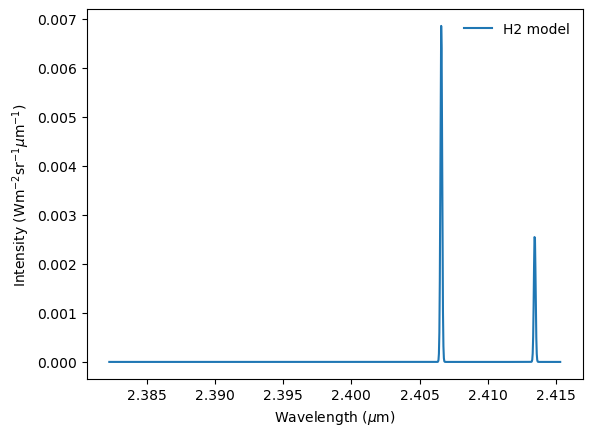

In [44]:
# Create the H3+ object
h2 = h3ppy.h2()

# Define a wavelength range, e.g. typical of an observation of the H3+ Q branch
# Specify the start and end wavelengths, and the number of wavelength elements
wave = waverange32[:1001]
# spec = fjc36_rs[1][20:240,:1001][170]
# spec = spec32_h2[0][150]

# Create a H3+ model spectrum for a set of physical parameters 
# Spectral resolution R = 1200, T = 1000, N = 1e14
# This is the minimum set of parameters required for generating a model
model = h2.model(density = 1e25, temperature = 850, R = 25000, wavelength = wave)

# Plot the model
fig, ax = plt.subplots()
ax.plot(wave, model, label = 'H2 model')
# ax.plot(wave, spec,'k', lw=0.8, label = 'Observation')
# ax.set_xlim(2.405,2.415)
# ax.set_xlim(2.121,2.123)

# Automagically set the labels 
ax.set_xlabel(h2.xlabel())
ax.set_ylabel(h2.ylabel())
# plt.savefig('example_model.png')
# plt.close() 
ax.legend(frameon = False)

/Users/RuoyanWang/anaconda3/lib/python3.11/site-packages/h3ppy


[h3ppy] Estimated density = 9.81E+14 m-2


/Users/RuoyanWang/anaconda3/lib/python3.11/site-packages/h3ppy


[h3ppy] Fit failed to converge - solution is numerially unstable 
[h3ppy] Estimated density = 1.47E+22 m-2
[h3ppy]  Spectrum parameters:
         Temperature    = 611.8 +/- 16.8 [K]
         Column density = 7.28E+22 +/-  2.83E+22 [m-2]
         ------------------------------
         background_0 = 2.46E-08 +/- 1.13E-08
         offset_0 = 2.69E-06 +/- 1.24E-06
         sigma_0 = 3.57E-05 +/- 1.29E-06



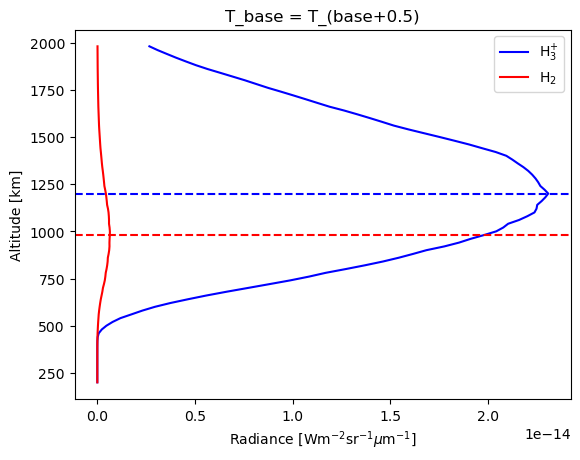

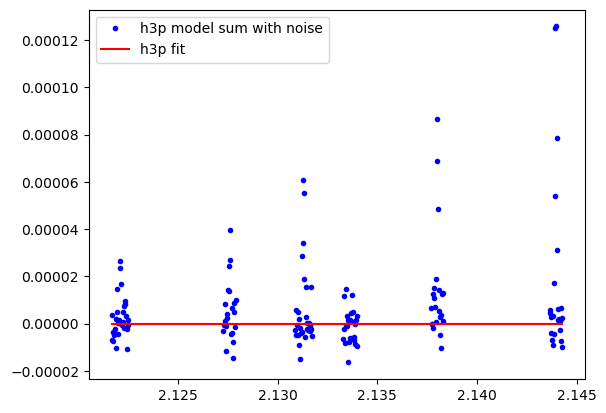

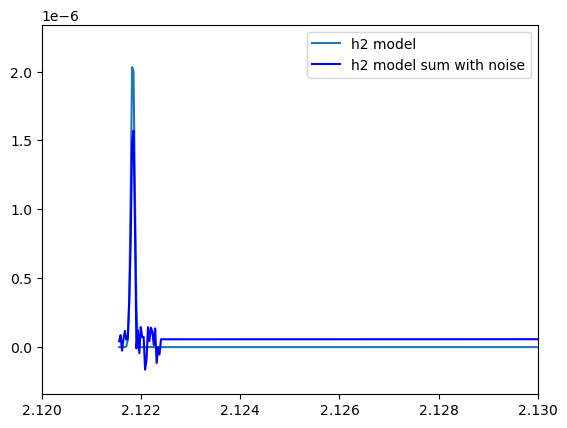

In [40]:
h3p = h3ppy.h3p()
h2 = h3ppy.h2()

h3p.set(wave = waveh3p, R = 25000)
h2.set(wave = waveh2, R = 25000)

h3p_radiance = []
h2_radiance = []

h3p_model_list = []
h2_model_list = []

delta_wave = waveh3p[1] - waveh3p[0]
delta_waveh2 = (waveh2[1] - waveh2[0])

for k, alt in enumerate(alt_scale):
    
    h3p.set(N = h3p_interp_m3[k], T = t_interp[k])
    h2.set(N = h2_interp_m3[k], T = t_interp[k])
    
    mh3p = np.sum(h3p.model() * delta_wave)
    mh2 = np.sum(h2.model() * delta_waveh2)

    h3p_model_list.append(h3p.model())
    h2_model_list.append(h2.model())

    h3p_radiance.append(mh3p)
    h2_radiance.append(mh2)

h3p_radiance = np.array(h3p_radiance)
h2_radiance = np.array(h2_radiance)


h3p_radiance_scaled = h3p_radiance*np.array(scaling_list)

h2_polyfit = np.polyfit(alt_scale, h2_radiance, 15)
h2_poly1d = np.poly1d(h2_polyfit)
h2_polynomial = h2_poly1d(alt_scale)

h3p_polyfit = np.polyfit(alt_scale, h3p_radiance_scaled, 15)
h3p_poly1d = np.poly1d(h3p_polyfit)
h3p_polynomial = h3p_poly1d(alt_scale)

plt.figure()
plt.plot(h3p_radiance_scaled, alt_scale, 'b-', label='H$_3^{+}$')
plt.plot(h2_radiance, alt_scale, 'r-', label='H$_2$')
# plt.plot(h2_polynomial, alt_scale, 'k-')
# plt.plot(h3p_polynomial, alt_scale, 'k-')

# plt.axhline(alt_scale[h3p_radiance_scaled == np.max(h3p_radiance_scaled)], color='b', ls='--')
# plt.axhline(alt_scale[h2_radiance == np.max(h2_radiance)], color='r', ls='--')

plt.axhline(alt_scale[h3p_polynomial == np.max(h3p_polynomial)], color='b', ls='--')
plt.axhline(alt_scale[h2_polynomial == np.max(h2_polynomial)], color='r', ls='--')


plt.xlabel('Radiance [Wm$^{-2}$sr$^{-1}$$\mu$m$^{-1}$]')
plt.ylabel('Altitude [km]')
plt.title(r'T_base = T_(base+{})'.format(i))
plt.legend()


#     plt.savefig(plots_dir+'rad_vs_alt_mode'+str(m)+'_T'+str("%.0f" % i), 
#     dpi=400, 
#     bbox_inches='tight', 
#     facecolor='white')

# fig.savefig(plots_dir+'temp_vs_alt_'+'mode'+str(m), 
#     dpi=400, 
#     bbox_inches='tight', 
#     facecolor='white')


h3p = h3ppy.h3p()

h3p.set(wave = waveh3p, R = 25000)

h3p_model_array = np.array(h3p_model_list)
h3p_model_sum = np.sum(h3p_model_array, axis=0)*20e3

snr = 10
scale = np.max(h3p_model_sum) / snr / 2.0
noise = np.random.normal(size = len(h3p_model_sum), scale = scale).flatten()

h3p_model_sum_with_noise = h3p_model_sum + noise

h3p.set(wave = waveh3p, data=h3p_model_sum_with_noise, T=900)

h3p.guess_density()

h3p_model = h3p.model()

h3p_fit = h3p.fit()

vars, errs = h3p.get_results()

plt.figure()
# plt.plot(waveh3p, h3p_model, label='h3p model')
plt.plot(waveh3p, h3p_model_sum_with_noise, 'b.', label='h3p model sum with noise')
plt.plot(waveh3p, h3p_fit, 'r-', label='h3p fit')
plt.legend()


h2 = h3ppy.h2()

h2.set(wave = waveh2, R = 25000)

h2_model_array = np.array(h2_model_list)
h2_model_sum = np.sum(h2_model_array, axis=0)*20e3

snr = 10
scale = np.max(h2_model_sum) / snr / 2.0
noise = np.random.normal(size = len(h2_model_sum), scale = scale).flatten()

h2_model_sum_with_noise = h2_model_sum + noise

h2.set(wave = waveh2, data=h2_model_sum_with_noise, T=700)

h2.guess_density()

h2_model = h2.model()

h2_fit = h2.fit()

vars, errs = h2.get_results()

plt.figure()
plt.plot(waveh2, h2_model, label='h2 model')
plt.plot(waveh2, h2_model_sum_with_noise, 'b-', label='h2 model sum with noise')
# plt.plot(waveh2, h2_fit, 'r-', label='h2 fit')
plt.xlim(2.12,2.13)
plt.legend()

/Users/RuoyanWang/anaconda3/lib/python3.11/site-packages/h3ppy


[h3ppy] Estimated density = 2.93E+16 m-2


/Users/RuoyanWang/anaconda3/lib/python3.11/site-packages/h3ppy


[h3ppy]  Spectrum parameters:
         Temperature    = 963.2 +/- 58.3 [K]
         Column density = 3.41E+16 +/-  1.22E+16 [m-2]
         ------------------------------
         background_0 = -4.65E-05 +/- 2.95E-05
         offset_0 = -4.44E-07 +/- 1.06E-06
         sigma_0 = 3.48E-05 +/- 1.10E-06

[h3ppy] Estimated density = 4.64E+23 m-2
[h3ppy]  Spectrum parameters:
         Temperature    = 930.9 +/- 47.9 [K]
         Column density = 2.93E+23 +/-  1.42E+23 [m-2]
         ------------------------------
         background_0 = 6.64E-06 +/- 6.96E-06
         offset_0 = 2.18E-07 +/- 1.48E-06
         sigma_0 = 3.64E-05 +/- 1.52E-06



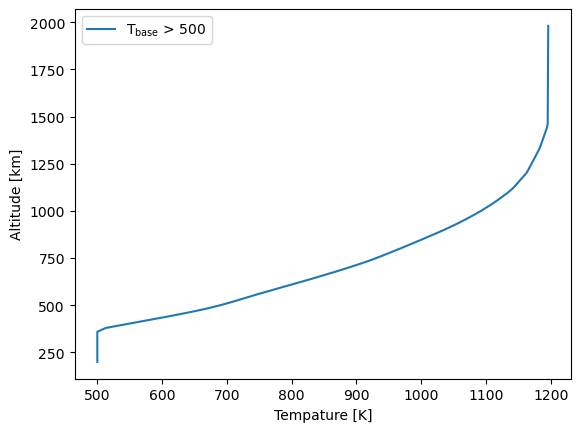

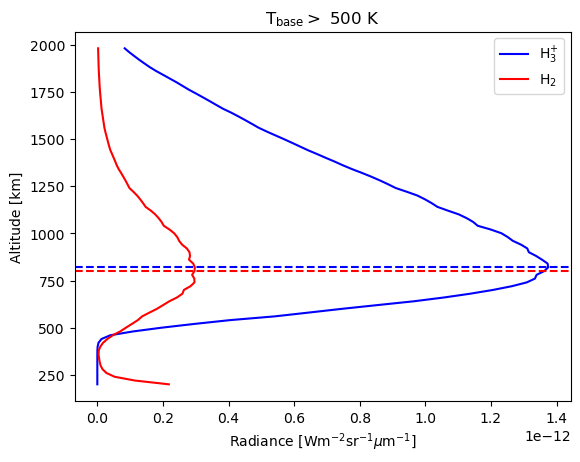

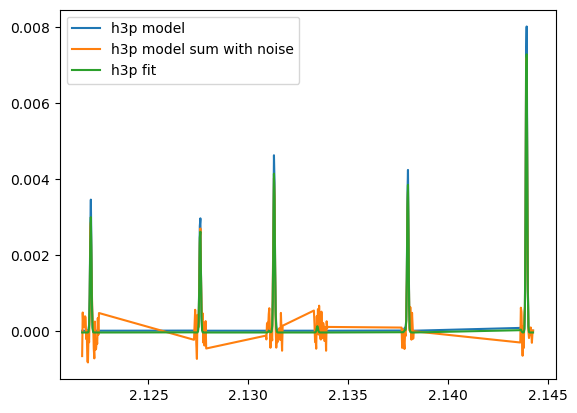

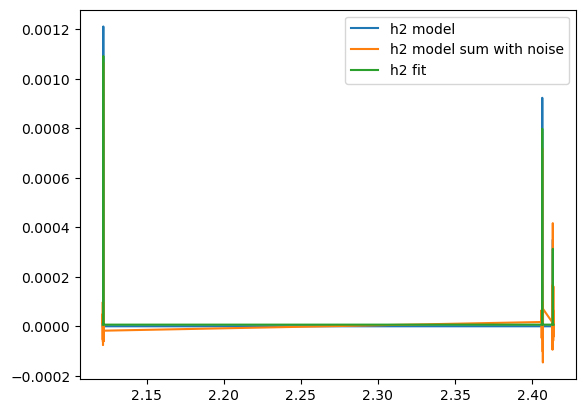

In [28]:
for m in mode:
    if m == 1:
        # t_base = np.arange(200, 1200, 100)
        t_base = [500]

        fig, ax = plt.subplots()
        
        for i in t_base:
            
            t_interp = np.interp(alt_scale, jup_tao_h, jup_tao_t)
            t_interp[t_interp < i] = i
            
            ax.plot(t_interp, alt_scale, label='$\mathrm{T_{base}}$ > '+str(i))
            ax.set_xlabel('Tempature [K]')
            ax.set_ylabel('Altitude [km]')
            ax.legend()


            scaling_list = []

            for j, alt in enumerate(alt_scale):
                scaling = non_LTE_scaling(t_interp[j], h2_interp_m3[j])
                # print(scaling)
            
                scaling_list.append(scaling)


            h3p = h3ppy.h3p()
            h2 = h3ppy.h2()
            
            h3p.set(wave = waveh3p, R = 25000)
            h2.set(wave = waveh2, R = 25000)
            
            h3p_radiance = []
            h2_radiance = []
            
            h3p_model_list = []
            h2_model_list = []
            
            delta_wave = waveh3p[1] - waveh3p[0]
            delta_waveh2 = (waveh2[1] - waveh2[0])
            
            for k, alt in enumerate(alt_scale):
                
                h3p.set(N = h3p_interp_m3[k], T = t_interp[k])
                h2.set(N = h2_interp_m3[k], T = t_interp[k])
                
                mh3p = np.sum(h3p.model() * delta_wave)
                mh2 = np.sum(h2.model() * delta_waveh2)
            
                h3p_model_list.append(h3p.model())
                h2_model_list.append(h2.model())
            
                h3p_radiance.append(mh3p)
                h2_radiance.append(mh2)
            
            h3p_radiance = np.array(h3p_radiance)
            h2_radiance = np.array(h2_radiance)



            h3p_radiance_scaled = h3p_radiance*np.array(scaling_list)

            h2_polyfit = np.polyfit(alt_scale, h2_radiance, 15)
            h2_poly1d = np.poly1d(h2_polyfit)
            h2_polynomial = h2_poly1d(alt_scale)
            
            h3p_polyfit = np.polyfit(alt_scale, h3p_radiance_scaled, 15)
            h3p_poly1d = np.poly1d(h3p_polyfit)
            h3p_polynomial = h3p_poly1d(alt_scale)
            
            plt.figure()
            plt.plot(h3p_radiance_scaled, alt_scale, 'b-', label='H$_3^{+}$')
            plt.plot(h2_radiance, alt_scale, 'r-', label='H$_2$')
            # plt.plot(h2_polynomial, alt_scale, 'k-')
            # plt.plot(h3p_polynomial, alt_scale, 'k-')
            
            # plt.axhline(alt_scale[h3p_radiance_scaled == np.max(h3p_radiance_scaled)], color='b', ls='--')
            # plt.axhline(alt_scale[h2_radiance == np.max(h2_radiance)], color='r', ls='--')
            
            plt.axhline(alt_scale[h3p_polynomial == np.max(h3p_polynomial)], color='b', ls='--')
            plt.axhline(alt_scale[h2_polynomial == np.max(h2_polynomial)], color='r', ls='--')
            
            
            plt.xlabel('Radiance [Wm$^{-2}$sr$^{-1}$$\mu$m$^{-1}$]')
            plt.ylabel('Altitude [km]')
            plt.title('$\mathrm{T_{base} >}$ '+str(i)+' K')
            # plt.title('$\mathrm{T_{base} = <T + >}$')
            plt.legend()

        #     plt.savefig(plots_dir+'rad_vs_alt_mode'+str(m)+'_T'+str("%.0f" % i), 
        #                 dpi=400, 
        #                 bbox_inches='tight', 
        #                 facecolor='white')

        # fig.savefig(plots_dir+'temp_vs_alt_'+'mode'+str(m), 
        #             dpi=400, 
        #             bbox_inches='tight', 
        #             facecolor='white')

            h3p = h3ppy.h3p()

            h3p.set(wave = waveh3p, R = 25000)
            
            h3p_model_array = np.array(h3p_model_list)
            h3p_model_sum = np.sum(h3p_model_array, axis=0)*20e3
            
            snr = 10
            scale = np.max(h3p_model_sum) / snr / 2.0
            noise = np.random.normal(size = len(h3p_model_sum), scale = scale).flatten()
            
            h3p_model_sum_with_noise = h3p_model_sum + noise
            
            h3p.set(wave = waveh3p, data=h3p_model_sum_with_noise, T=1000)
            
            h3p.guess_density()
            
            h3p_model = h3p.model()
            
            h3p_fit = h3p.fit()
            
            vars, errs = h3p.get_results()

            plt.figure()
            plt.plot(waveh3p, h3p_model, label='h3p model')
            plt.plot(waveh3p, h3p_model_sum_with_noise, label='h3p model sum with noise')
            plt.plot(waveh3p, h3p_fit, label='h3p fit')
            plt.legend()


            h2 = h3ppy.h2()

            h2.set(wave = waveh2, R = 25000)
            
            h2_model_array = np.array(h2_model_list)
            h2_model_sum = np.sum(h2_model_array, axis=0)*20e3
            
            snr = 10
            scale = np.max(h2_model_sum) / snr / 2.0
            noise = np.random.normal(size = len(h2_model_sum), scale = scale).flatten()
            
            h2_model_sum_with_noise = h2_model_sum + noise
            
            h2.set(wave = waveh2, data=h2_model_sum_with_noise, T=900)
            
            h2.guess_density()
            
            h2_model = h2.model()
            
            h2_fit = h2.fit()
            
            vars, errs = h2.get_results()

            plt.figure()
            # plt.plot(waveh2, h2_model, label='h2 model')
            plt.plot(waveh2, h2_model_sum_with_noise, label='h2 model sum with noise')
            plt.plot(waveh2, h2_fit, label='h2 fit')
            plt.legend()
            

/Users/RuoyanWang/anaconda3/lib/python3.11/site-packages/h3ppy


[h3ppy] Estimated density = 1.10E+17 m-2


/Users/RuoyanWang/anaconda3/lib/python3.11/site-packages/h3ppy


[h3ppy]  Spectrum parameters:
         Temperature    = 1212.8 +/- 81.9 [K]
         Column density = 3.93E+16 +/-  1.15E+16 [m-2]
         ------------------------------
         background_0 = -1.29E-05 +/- 1.24E-04
         offset_0 = -9.52E-07 +/- 1.15E-06
         sigma_0 = 3.47E-05 +/- 1.19E-06

[h3ppy] Estimated density = 1.61E+25 m-2
[h3ppy]  Spectrum parameters:
         Temperature    = 957.3 +/- 44.5 [K]
         Column density = 7.36E+24 +/-  3.13E+24 [m-2]
         ------------------------------
         background_0 = -1.06E-04 +/- 1.95E-04
         offset_0 = -2.44E-07 +/- 1.29E-06
         sigma_0 = 3.67E-05 +/- 1.33E-06



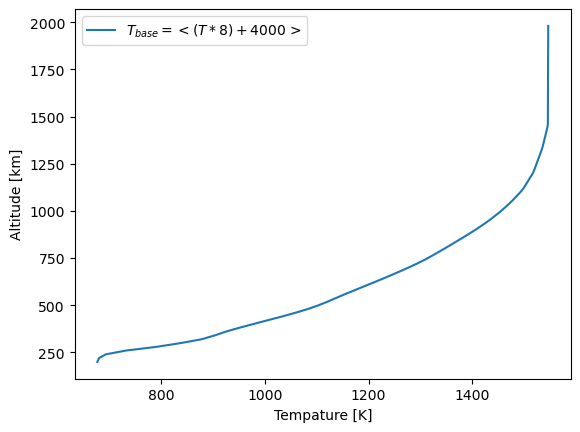

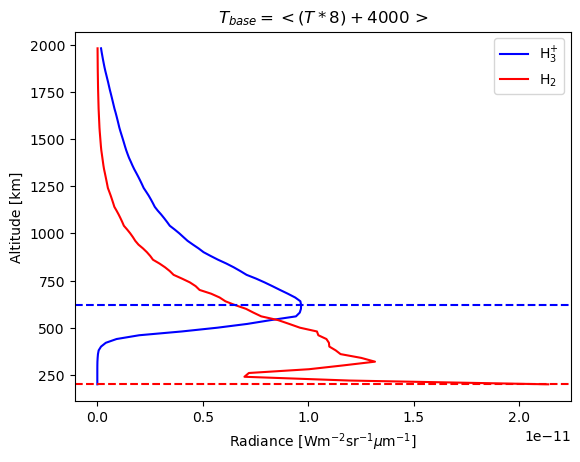

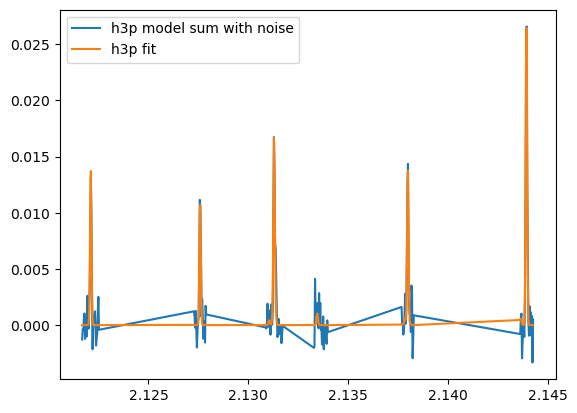

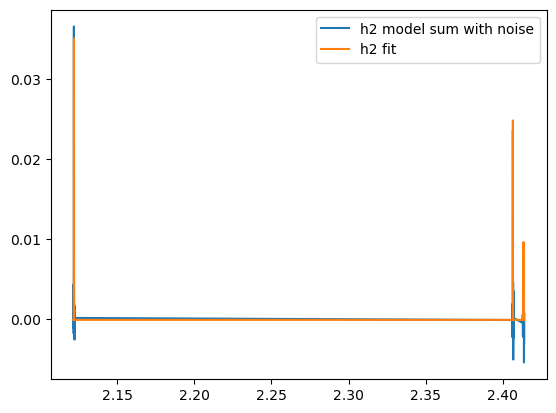

In [19]:
for m in mode:
    if m == 2:
        t_base = 4000

        # order = np.arange(2, 6, 1)
        order = [8]

        fig, ax = plt.subplots()

        for i in order:
            
            t_interp1 = np.interp(alt_scale, jup_tao_h, jup_tao_t)
            t_interp2 = np.zeros(len(t_interp1)) + t_base
            t_interp = (t_interp1*(i-1) + t_interp2)/(i)
            
            ax.plot(t_interp, alt_scale, label=r'$T_{base} = < (T * $'+str(i)+r'$) + $'+str(t_base)+' >')
            ax.set_xlabel('Tempature [K]')
            ax.set_ylabel('Altitude [km]')
            ax.legend()

        
            scaling_list = []

            for j, alt in enumerate(alt_scale):
                scaling = non_LTE_scaling(t_interp[j], h2_interp_m3[j])
                # print(scaling)
            
                scaling_list.append(scaling)


            h3p = h3ppy.h3p()
            h2 = h3ppy.h2()
            
            h3p.set(wave = waveh3p, R = 25000)
            h2.set(wave = waveh2, R = 25000)
            
            h3p_radiance = []
            h2_radiance = []
            
            h3p_model_list = []
            h2_model_list = []
            
            delta_wave = waveh3p[1] - waveh3p[0]
            delta_waveh2 = (waveh2[1] - waveh2[0])
            
            for k, alt in enumerate(alt_scale):
                
                h3p.set(N = h3p_interp_m3[k], T = t_interp[k])
                h2.set(N = h2_interp_m3[k], T = t_interp[k])
                
                mh3p = np.sum(h3p.model() * delta_wave)
                mh2 = np.sum(h2.model() * delta_waveh2)
            
                h3p_model_list.append(h3p.model())
                h2_model_list.append(h2.model())
            
                h3p_radiance.append(mh3p)
                h2_radiance.append(mh2)
            
            h3p_radiance = np.array(h3p_radiance)
            h2_radiance = np.array(h2_radiance)


            h3p_radiance_scaled = h3p_radiance*np.array(scaling_list)

            h2_polyfit = np.polyfit(alt_scale, h2_radiance, 15)
            h2_poly1d = np.poly1d(h2_polyfit)
            h2_polynomial = h2_poly1d(alt_scale)
            
            h3p_polyfit = np.polyfit(alt_scale, h3p_radiance_scaled, 15)
            h3p_poly1d = np.poly1d(h3p_polyfit)
            h3p_polynomial = h3p_poly1d(alt_scale)
            
            plt.figure()
            plt.plot(h3p_radiance_scaled, alt_scale, 'b-', label='H$_3^{+}$')
            plt.plot(h2_radiance, alt_scale, 'r-', label='H$_2$')
            # plt.plot(h2_polynomial, alt_scale, 'k-')
            # plt.plot(h3p_polynomial, alt_scale, 'k-')
            
            # plt.axhline(alt_scale[h3p_radiance_scaled == np.max(h3p_radiance_scaled)], color='b', ls='--')
            # plt.axhline(alt_scale[h2_radiance == np.max(h2_radiance)], color='r', ls='--')
            
            plt.axhline(alt_scale[h3p_polynomial == np.max(h3p_polynomial)], color='b', ls='--')
            plt.axhline(alt_scale[h2_polynomial == np.max(h2_polynomial)], color='r', ls='--')
            
            
            plt.xlabel('Radiance [Wm$^{-2}$sr$^{-1}$$\mu$m$^{-1}$]')
            plt.ylabel('Altitude [km]')
            plt.title(r'$T_{base} = < (T * $'+str(i)+r'$) + $'+str(t_base)+' >')
            plt.legend()

        #     plt.savefig(plots_dir+'rad_vs_alt_mode'+str(m)+'_x'+str("%.0f" % i)+'_T'+str(t_base),
        #                 dpi=400, 
        #                 bbox_inches='tight', 
        #                 facecolor='white')

        # fig.savefig(plots_dir+'temp_vs_alt_'+'mode'+str(m), 
        #     dpi=400, 
        #     bbox_inches='tight', 
        #     facecolor='white')



            h3p = h3ppy.h3p()

            h3p.set(wave = waveh3p, R = 25000)
            
            h3p_model_array = np.array(h3p_model_list)
            h3p_model_sum = np.sum(h3p_model_array, axis=0)*20e3
            
            snr = 10
            scale = np.max(h3p_model_sum) / snr / 2.0
            noise = np.random.normal(size = len(h3p_model_sum), scale = scale).flatten()
            
            h3p_model_sum_with_noise = h3p_model_sum + noise
            
            h3p.set(wave = waveh3p, data=h3p_model_sum_with_noise, T=1000)
            
            h3p.guess_density()
            
            h3p_model = h3p.model()
            
            h3p_fit = h3p.fit()
            
            vars, errs = h3p.get_results()

            plt.figure()
            # plt.plot(waveh3p, h3p_model, label='h3p model')
            plt.plot(waveh3p, h3p_model_sum_with_noise, label='h3p model sum with noise')
            plt.plot(waveh3p, h3p_fit, label='h3p fit')
            plt.legend()


            h2 = h3ppy.h2()

            h2.set(wave = waveh2, R = 25000)
            
            h2_model_array = np.array(h2_model_list)
            h2_model_sum = np.sum(h2_model_array, axis=0)*20e3
            
            snr = 10
            scale = np.max(h2_model_sum) / snr / 2.0
            noise = np.random.normal(size = len(h2_model_sum), scale = scale).flatten()
            
            h2_model_sum_with_noise = h2_model_sum + noise
            
            h2.set(wave = waveh2, data=h2_model_sum_with_noise, T=900)
            
            h2.guess_density()
            
            h2_model = h2.model()
            
            h2_fit = h2.fit()
            
            vars, errs = h2.get_results()

            plt.figure()
            # plt.plot(waveh2, h2_model, label='h2 model')
            plt.plot(waveh2, h2_model_sum_with_noise, label='h2 model sum with noise')
            plt.plot(waveh2, h2_fit, label='h2 fit')
            plt.legend()

/Users/RuoyanWang/anaconda3/lib/python3.11/site-packages/h3ppy


[h3ppy] Estimated density = 7.04E+16 m-2
[h3ppy] Fit failed to converge - solution is numerially unstable 
[h3ppy] Estimated density = 8.93E+23 m-2


/Users/RuoyanWang/anaconda3/lib/python3.11/site-packages/h3ppy


[h3ppy]  Spectrum parameters:
         Temperature    = 962.8 +/- 44.8 [K]
         Column density = 4.29E+23 +/-  1.81E+23 [m-2]
         ------------------------------
         background_0 = -1.80E-05 +/- 1.17E-05
         offset_0 = 9.96E-07 +/- 1.34E-06
         sigma_0 = 3.83E-05 +/- 1.38E-06



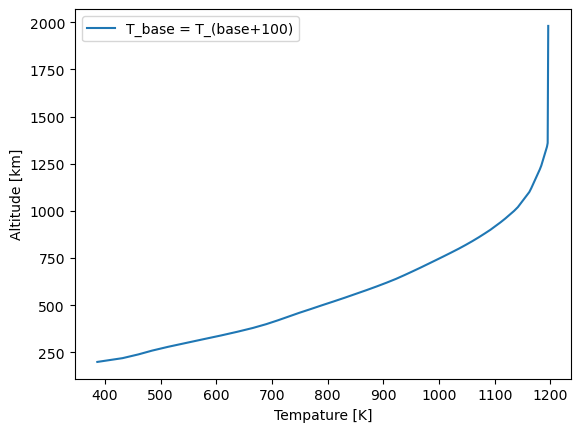

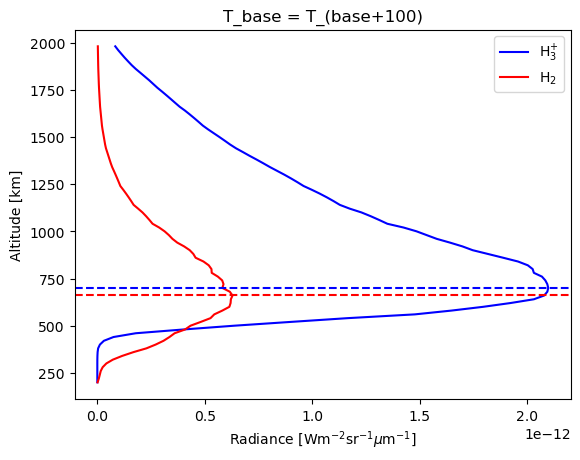

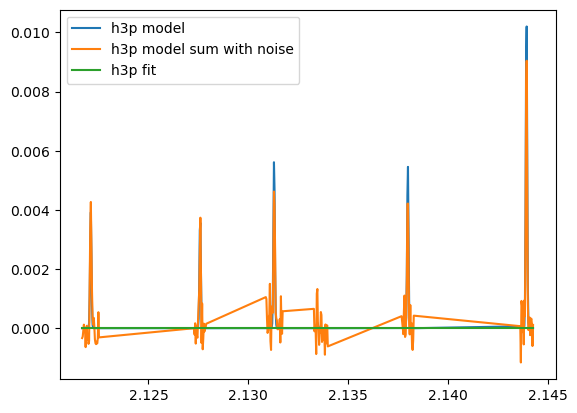

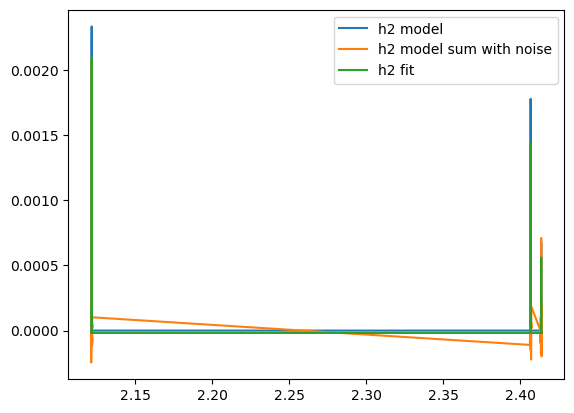

In [31]:
for m in mode:
    if m == 3:
        # t_base = np.arange(200, 1200, 100)
        t_base = [100]

        fig, ax = plt.subplots()

        for i in t_base:
            
            t_interp = np.interp(alt_scale + i, jup_tao_h, jup_tao_t)
            # t_interp = (t_interp1 + i)
            
            ax.plot(t_interp, alt_scale, label=r'T_base = T_(base+{})'.format(i))
            ax.set_xlabel('Tempature [K]')
            ax.set_ylabel('Altitude [km]')
            ax.legend()

            
            scaling_list = []

            for j, alt in enumerate(alt_scale):
                scaling = non_LTE_scaling(t_interp[j], h2_interp_m3[j])
                # print(scaling)
            
                scaling_list.append(scaling)


            h3p = h3ppy.h3p()
            h2 = h3ppy.h2()
            
            h3p.set(wave = waveh3p, R = 25000)
            h2.set(wave = waveh2, R = 25000)
            
            h3p_radiance = []
            h2_radiance = []
            
            h3p_model_list = []
            h2_model_list = []
            
            delta_wave = waveh3p[1] - waveh3p[0]
            delta_waveh2 = (waveh2[1] - waveh2[0])
            
            for k, alt in enumerate(alt_scale):
                
                h3p.set(N = h3p_interp_m3[k], T = t_interp[k])
                h2.set(N = h2_interp_m3[k], T = t_interp[k])
                
                mh3p = np.sum(h3p.model() * delta_wave)
                mh2 = np.sum(h2.model() * delta_waveh2)
            
                h3p_model_list.append(h3p.model())
                h2_model_list.append(h2.model())
            
                h3p_radiance.append(mh3p)
                h2_radiance.append(mh2)
            
            h3p_radiance = np.array(h3p_radiance)
            h2_radiance = np.array(h2_radiance)


            h3p_radiance_scaled = h3p_radiance*np.array(scaling_list)

            h2_polyfit = np.polyfit(alt_scale, h2_radiance, 15)
            h2_poly1d = np.poly1d(h2_polyfit)
            h2_polynomial = h2_poly1d(alt_scale)
            
            h3p_polyfit = np.polyfit(alt_scale, h3p_radiance_scaled, 15)
            h3p_poly1d = np.poly1d(h3p_polyfit)
            h3p_polynomial = h3p_poly1d(alt_scale)
            
            plt.figure()
            plt.plot(h3p_radiance_scaled, alt_scale, 'b-', label='H$_3^{+}$')
            plt.plot(h2_radiance, alt_scale, 'r-', label='H$_2$')
            # plt.plot(h2_polynomial, alt_scale, 'k-')
            # plt.plot(h3p_polynomial, alt_scale, 'k-')
            
            # plt.axhline(alt_scale[h3p_radiance_scaled == np.max(h3p_radiance_scaled)], color='b', ls='--')
            # plt.axhline(alt_scale[h2_radiance == np.max(h2_radiance)], color='r', ls='--')
            
            plt.axhline(alt_scale[h3p_polynomial == np.max(h3p_polynomial)], color='b', ls='--')
            plt.axhline(alt_scale[h2_polynomial == np.max(h2_polynomial)], color='r', ls='--')
            
            
            plt.xlabel('Radiance [Wm$^{-2}$sr$^{-1}$$\mu$m$^{-1}$]')
            plt.ylabel('Altitude [km]')
            plt.title(r'T_base = T_(base+{})'.format(i))
            plt.legend()


        #     plt.savefig(plots_dir+'rad_vs_alt_mode'+str(m)+'_T'+str("%.0f" % i), 
        #     dpi=400, 
        #     bbox_inches='tight', 
        #     facecolor='white')

        # fig.savefig(plots_dir+'temp_vs_alt_'+'mode'+str(m), 
        #     dpi=400, 
        #     bbox_inches='tight', 
        #     facecolor='white')


            h3p = h3ppy.h3p()

            h3p.set(wave = waveh3p, R = 25000)
            
            h3p_model_array = np.array(h3p_model_list)
            h3p_model_sum = np.sum(h3p_model_array, axis=0)*20e3
            
            snr = 10
            scale = np.max(h3p_model_sum) / snr / 2.0
            noise = np.random.normal(size = len(h3p_model_sum), scale = scale).flatten()
            
            h3p_model_sum_with_noise = h3p_model_sum + noise
            
            h3p.set(wave = waveh3p, data=h3p_model_sum_with_noise, T=900)
            
            h3p.guess_density()
            
            h3p_model = h3p.model()
            
            h3p_fit = h3p.fit()
            
            vars, errs = h3p.get_results()

            plt.figure()
            plt.plot(waveh3p, h3p_model, label='h3p model')
            plt.plot(waveh3p, h3p_model_sum_with_noise, label='h3p model sum with noise')
            plt.plot(waveh3p, h3p_fit, label='h3p fit')
            plt.legend()


            h2 = h3ppy.h2()

            h2.set(wave = waveh2, R = 25000)
            
            h2_model_array = np.array(h2_model_list)
            h2_model_sum = np.sum(h2_model_array, axis=0)*20e3
            
            snr = 10
            scale = np.max(h2_model_sum) / snr / 2.0
            noise = np.random.normal(size = len(h2_model_sum), scale = scale).flatten()
            
            h2_model_sum_with_noise = h2_model_sum + noise
            
            h2.set(wave = waveh2, data=h2_model_sum_with_noise, T=900)
            
            h2.guess_density()
            
            h2_model = h2.model()
            
            h2_fit = h2.fit()
            
            vars, errs = h2.get_results()

            plt.figure()
            # plt.plot(waveh2, h2_model, label='h2 model')
            plt.plot(waveh2, h2_model_sum_with_noise, label='h2 model sum with noise')
            plt.plot(waveh2, h2_fit, label='h2 fit')
            plt.legend()

/Users/RuoyanWang/anaconda3/lib/python3.11/site-packages/h3ppy


[h3ppy] Estimated density = 1.90E+16 m-2


/Users/RuoyanWang/anaconda3/lib/python3.11/site-packages/h3ppy


[h3ppy]  Spectrum parameters:
         Temperature    = 1108.5 +/- 84.5 [K]
         Column density = 9.65E+15 +/-  3.65E+15 [m-2]
         ------------------------------
         background_0 = -1.24E-05 +/- 2.24E-05
         offset_0 = 1.39E-06 +/- 1.36E-06
         sigma_0 = 3.63E-05 +/- 1.42E-06

[h3ppy] Estimated density = 2.08E+23 m-2
[h3ppy]  Spectrum parameters:
         Temperature    = 969.4 +/- 48.9 [K]
         Column density = 8.96E+22 +/-  4.08E+22 [m-2]
         ------------------------------
         background_0 = 3.96E-08 +/- 2.83E-06
         offset_0 = -1.55E-06 +/- 1.38E-06
         sigma_0 = 3.70E-05 +/- 1.43E-06



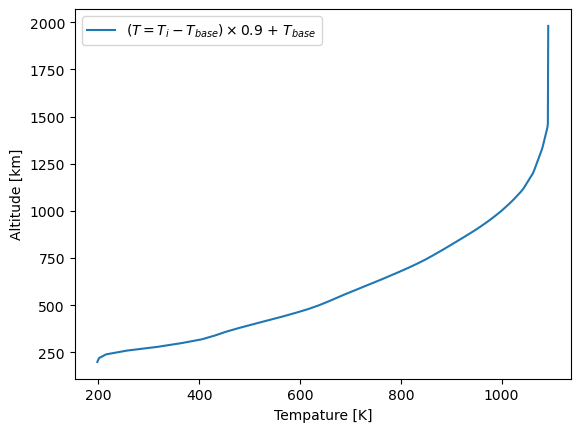

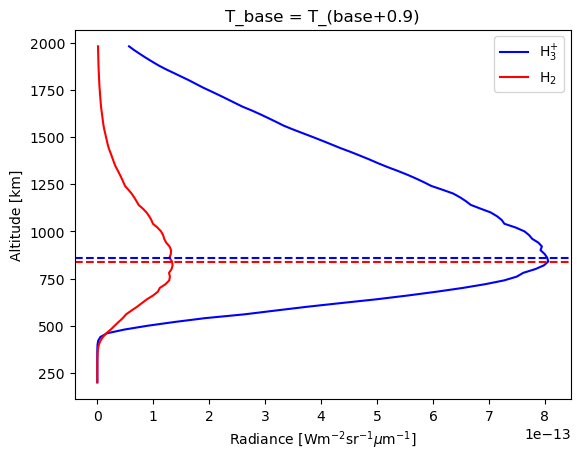

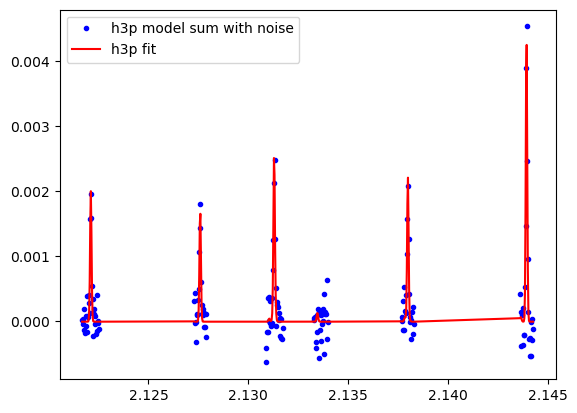

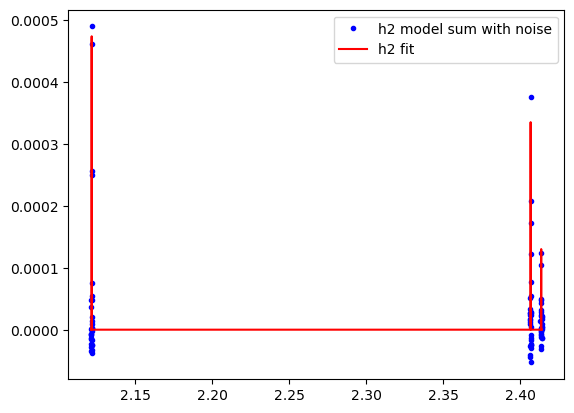

In [2]:
for m in mode:
    if m == 4:
        t_base = 161 # Melin et al. 2006

        # scaling_factor = [0.8, 0.9, 1.0, 1.1, 1.2]
        scaling_factor = [0.9]

        fig, ax = plt.subplots()

        for i in scaling_factor:
            
            t_interp1 = np.interp(alt_scale + i, jup_tao_h, jup_tao_t)
            t_interp = (t_interp1 - t_base) * i + t_base
            
            ax.plot(t_interp, alt_scale, label=r'$(T = T_i - T_{base}) \times $'+str(i) + r' + $T_{base}$')
            ax.set_xlabel('Tempature [K]')
            ax.set_ylabel('Altitude [km]')
            ax.legend()

            
            scaling_list = []

            for j, alt in enumerate(alt_scale):
                scaling = non_LTE_scaling(t_interp[j], h2_interp_m3[j])
                # print(scaling)
            
                scaling_list.append(scaling)


            h3p = h3ppy.h3p()
            h2 = h3ppy.h2()
            
            h3p.set(wave = waveh3p, R = 25000)
            h2.set(wave = waveh2, R = 25000)
            
            h3p_radiance = []
            h2_radiance = []
            
            h3p_model_list = []
            h2_model_list = []
            
            delta_wave = waveh3p[1] - waveh3p[0]
            delta_waveh2 = (waveh2[1] - waveh2[0])
            
            for k, alt in enumerate(alt_scale):
                
                h3p.set(N = h3p_interp_m3[k], T = t_interp[k])
                h2.set(N = h2_interp_m3[k], T = t_interp[k])
                
                mh3p = np.sum(h3p.model() * delta_wave)
                mh2 = np.sum(h2.model() * delta_waveh2)
            
                h3p_model_list.append(h3p.model())
                h2_model_list.append(h2.model())
            
                h3p_radiance.append(mh3p)
                h2_radiance.append(mh2)
            
            h3p_radiance = np.array(h3p_radiance)
            h2_radiance = np.array(h2_radiance)


            h3p_radiance_scaled = h3p_radiance*np.array(scaling_list)

            h2_polyfit = np.polyfit(alt_scale, h2_radiance, 15)
            h2_poly1d = np.poly1d(h2_polyfit)
            h2_polynomial = h2_poly1d(alt_scale)
            
            h3p_polyfit = np.polyfit(alt_scale, h3p_radiance_scaled, 15)
            h3p_poly1d = np.poly1d(h3p_polyfit)
            h3p_polynomial = h3p_poly1d(alt_scale)
            
            plt.figure()
            plt.plot(h3p_radiance_scaled, alt_scale, 'b-', label='H$_3^{+}$')
            plt.plot(h2_radiance, alt_scale, 'r-', label='H$_2$')
            # plt.plot(h2_polynomial, alt_scale, 'k-')
            # plt.plot(h3p_polynomial, alt_scale, 'k-')
            
            # plt.axhline(alt_scale[h3p_radiance_scaled == np.max(h3p_radiance_scaled)], color='b', ls='--')
            # plt.axhline(alt_scale[h2_radiance == np.max(h2_radiance)], color='r', ls='--')
            
            plt.axhline(alt_scale[h3p_polynomial == np.max(h3p_polynomial)], color='b', ls='--')
            plt.axhline(alt_scale[h2_polynomial == np.max(h2_polynomial)], color='r', ls='--')
            
            
            plt.xlabel('Radiance [Wm$^{-2}$sr$^{-1}$$\mu$m$^{-1}$]')
            plt.ylabel('Altitude [km]')
            plt.title(r'T_base = T_(base+{})'.format(i))
            plt.legend()


        #     plt.savefig(plots_dir+'rad_vs_alt_mode'+str(m)+'_T'+str("%.0f" % i), 
        #     dpi=400, 
        #     bbox_inches='tight', 
        #     facecolor='white')

        # fig.savefig(plots_dir+'temp_vs_alt_'+'mode'+str(m), 
        #     dpi=400, 
        #     bbox_inches='tight', 
        #     facecolor='white')


            h3p = h3ppy.h3p()

            h3p.set(wave = waveh3p, R = 25000)
            
            h3p_model_array = np.array(h3p_model_list)
            h3p_model_sum = np.sum(h3p_model_array, axis=0)*20e3
            
            snr = 10
            scale = np.max(h3p_model_sum) / snr / 2.0
            noise = np.random.normal(size = len(h3p_model_sum), scale = scale).flatten()
            
            h3p_model_sum_with_noise = h3p_model_sum + noise
            
            h3p.set(wave = waveh3p, data=h3p_model_sum_with_noise, T=1000)
            
            h3p.guess_density()
            
            h3p_model = h3p.model()
            
            h3p_fit = h3p.fit()
            
            vars, errs = h3p.get_results()

            plt.figure()
            # plt.plot(waveh3p, h3p_model, label='h3p model')
            plt.plot(waveh3p, h3p_model_sum_with_noise, 'b.', label='h3p model sum with noise')
            plt.plot(waveh3p, h3p_fit, 'r-', label='h3p fit')
            plt.legend()


            h2 = h3ppy.h2()

            h2.set(wave = waveh2, R = 25000)
            
            h2_model_array = np.array(h2_model_list)
            h2_model_sum = np.sum(h2_model_array, axis=0)*20e3
            
            snr = 10
            scale = np.max(h2_model_sum) / snr / 2.0
            noise = np.random.normal(size = len(h2_model_sum), scale = scale).flatten()
            
            h2_model_sum_with_noise = h2_model_sum + noise
            
            h2.set(wave = waveh2, data=h2_model_sum_with_noise, T=900)
            
            h2.guess_density()
            
            h2_model = h2.model()
            
            h2_fit = h2.fit()
            
            vars, errs = h2.get_results()

            plt.figure()
            # plt.plot(waveh2, h2_model, label='h2 model')
            plt.plot(waveh2, h2_model_sum_with_noise, 'b.', label='h2 model sum with noise')
            plt.plot(waveh2, h2_fit, 'r-', label='h2 fit')
            # plt.xlim(2.12,2.13)
            plt.legend()